In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc 

% matplotlib inline

In [16]:
df = pd.read_csv('data/train_date.csv.zip', index_col=0, nrows=10000)

In [17]:
response = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969])

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [18]:
print(df.shape)
df.dropna(axis=0, how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)
print(df.shape)

(10000, 1156)
(9997, 1145)


In [19]:
# find the first feature in each station
cols = df.columns.tolist()
stations = []
a = list(set(x.split('_')[1] for x in cols))
for c in cols:
    tmp = c.split('_')[1]
    if (tmp not in stations) and (tmp in a):
        stations.append(c)
        a.remove(tmp)        
del a, tmp, c, cols
gc.collect()
stations.insert(0, 'Id')
print(stations)

['Id', 'L0_S0_D1', 'L0_S1_D26', 'L0_S2_D34', 'L0_S3_D70', 'L0_S4_D106', 'L0_S5_D115', 'L0_S6_D120', 'L0_S7_D137', 'L0_S8_D145', 'L0_S9_D152', 'L0_S10_D216', 'L0_S11_D280', 'L0_S12_D331', 'L0_S13_D355', 'L0_S14_D360', 'L0_S15_D395', 'L0_S16_D423', 'L0_S17_D432', 'L0_S18_D437', 'L0_S19_D454', 'L0_S20_D462', 'L0_S21_D469', 'L0_S22_D543', 'L0_S23_D617', 'L1_S24_D677', 'L1_S25_D1854', 'L2_S26_D3037', 'L2_S27_D3130', 'L2_S28_D3223', 'L3_S29_D3316', 'L3_S30_D3496', 'L3_S31_D3836', 'L3_S32_D3852', 'L3_S33_D3856', 'L3_S34_D3875', 'L3_S35_D3886', 'L3_S36_D3919', 'L3_S37_D3942', 'L3_S38_D3953', 'L3_S39_D3966', 'L3_S40_D3981', 'L3_S41_D3997', 'L3_S43_D4062', 'L3_S44_D4101', 'L3_S45_D4125', 'L3_S47_D4140', 'L3_S48_D4194', 'L3_S49_D4208', 'L3_S50_D4242', 'L3_S51_D4255']


In [20]:
date = pd.read_csv('data/train_date.csv.zip', index_col=0, usecols=stations)

df = date.copy()
df['date_start'] = df.min(axis=1)
df['date_end'] = df.max(axis=1)
df['duration'] = df.date_end - df.date_end

stations.remove('Id')

df.drop(stations, axis=1, inplace=True)

df = df.merge(response, left_index=True, right_index=True)

df = df.reset_index()

C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [22]:
df.sort_values(['date_start', 'Id'], inplace=True)

df['diff_Id1'] = df.Id.diff(1).fillna(2*10**6).astype(int) # ID difference when sorted by `date_start`
df.head()

,Id,date_start,date_end,duration,Response,diff_Id1
325556,651542,0.00,1.53,0.0,0,2000000
54038,108193,0.01,1.61,0.0,0,-543349
260490,521262,0.01,1.53,0.0,0,413069
293761,587799,0.01,1.52,0.0,0,66537
298264,596800,0.01,1.52,0.0,0,9001


C:\Users\home\Anaconda3\envs\kaggle\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


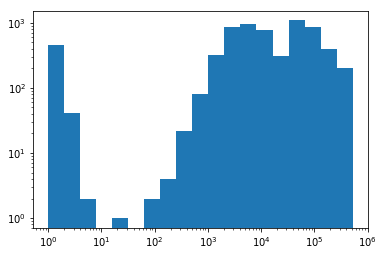

In [41]:
hist_bins = 2**np.arange(20)
a = plt.hist(np.abs(df.diff_Id1[df.Response==1]), log=True, bins=hist_bins, normed=False)
plt.xscale('log')

In [44]:
a[1]

array([     1,      2,      4,      8,     16,     32,     64,    128,
          256,    512,   1024,   2048,   4096,   8192,  16384,  32768,
        65536, 131072, 262144, 524288], dtype=int32)

In [51]:
date_start = df.date_start.unique()

In [52]:
df.dropna(subset=['date_start'], axis=0, inplace=True)

In [53]:
date = df.groupby('date_start')['Response'].agg(['mean', 'sum', 'count']).sort_values(by=['sum', 'mean', 'count'], ascending=False).reset_index()

In [154]:
pp = {}

for n in range(400):
    
    x = df.loc[df.date_start==date.date_start[n]].copy()

    x['diff'] = x['Id'].diff().fillna(99999999).astype(int)
    x['corr'] = x.Response.rolling(2).sum().fillna(99999999).astype(int)
    x = x.iloc[1:]

    if 1 in x['diff'].values:
        x.groupby('diff').corr.agg(['mean', 'count', 'sum']).loc[1]
        a.append(len(x[(x['diff']==1) & (x['corr']==2)])/len(x))
        pp[n] = [date.date_start[n], len(x[(x['diff']==1) & (x['corr']==2)])/len(x), len(x[(x['diff']==1) & (x['corr']==2)]), len(x)]

pp = pd.DataFrame.from_dict(pp, orient='index')

pp.columns = ['start_date', 'error_rate', 'error_count', 'total_count']

rate = pp.error_count.sum()/pp.total_count.sum()

In [155]:
rate

0.031465247338760174